In [1]:
import sys
import os
sys.path.append('/home/franzi/anzeigendaten/python_base/skillextraktion/fh_ma')
sys.path.append('/home/franzi/anzeigendaten/EnvPython')
import prepare_training_data
from labels import *
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle

start = time.time()
x_train, y_train, x_test, y_test, test_afks, features = prepare_training_data.get_training_data(word_features=True, wf_window=4)
print('took: ',time.time()-start)

20861874
0
skipgram, punctuation_marks, stoppwords, multiword, lower_case, vector_dim True False False False False 100
init /home/franzi/Documents/models/no_pm_no_sw_vecDim100/skip_gram_model.model
loading existing w2v model from  /home/franzi/Documents/models/no_pm_no_sw_vecDim100/skip_gram_model.model
using data from  /home/franzi/Documents/data/data_wFeatures_4_wf4_vecDim100
loading data...
37823 37823 12053 12053 0 0
took:  3.9967219829559326


In [ ]:
import numpy as np
for i,f in enumerate(features):
    features[i] = np.array(f)
pos_test, wf_test, bg_test, pos_train, wf_train, bg_train,  _, _, _ = features

In [5]:
from tensorflow.keras import *

In [6]:
# Build the model
print('Build model...')

vector_window_input = layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
vw = layers.LSTM(256, return_sequences=True)(vector_window_input)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.LSTM(512, return_sequences=True)(vw)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.LSTM(512)(vw)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.Dense(128, activation='relu')(vw)

wf_input = layers.Input(shape=(len(wf_train[0]), len(wf_train[0][1])))
f = layers.Dense(512, activation='relu')(wf_input)
f = layers.Dropout(0.5)(f)
f = layers.Dense(256, activation='relu')(f)
f = layers.Flatten()(f)

x = layers.concatenate([vw, f])
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)

out = layers.Dense(units=len(labels), activation='softplus')(x)
model = models.Model(inputs=[vector_window_input, wf_input], outputs=[out])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.evaluate(x=[x_test, wf_test], y=y_test)

batch_size=32
history = model.fit([x_train, wf_train], y_train, batch_size=batch_size, shuffle=True, epochs=5, validation_data=([x_test, wf_test], y_test))

2020-08-19 12:04:04 WARNING: From /home/franzi/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Build model...
12053/12053 [==============================] - 27s 2ms/sample - loss: 2.0845 - acc: 0.0277
Train on 37823 samples, validate on 12053 samples


2020-08-19 12:04:35 WARNING: From /home/franzi/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
37823/37823 [==============================] - 214s 6ms/sample - loss: 0.8075 - acc: 0.7065 - val_loss: 0.6784 - val_acc: 0.7590
Epoch 2/5
37823/37823 [==============================] - 201s 5ms/sample - loss: 0.5868 - acc: 0.7867 - val_loss: 0.5212 - val_acc: 0.8242
Epoch 3/5
37823/37823 [==============================] - 197s 5ms/sample - loss: 0.4716 - acc: 0.8332 - val_loss: 0.4871 - val_acc: 0.8315
Epoch 4/5
37823/37823 [==============================] - 197s 5ms/sample - loss: 0.4316 - acc: 0.8473 - val_loss: 0.4430 - val_acc: 0.8489
Epoch 5/5
37823/37823 [==============================] - 196s 5ms/sample - loss: 0.3993 - acc: 0.8590 - val_loss: 0.4325 - val_acc: 0.8502


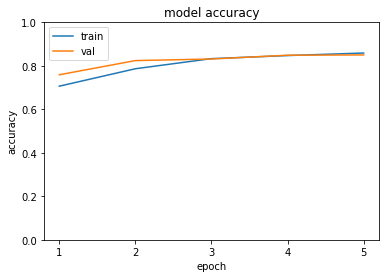

In [7]:
from matplotlib import pyplot as plt
plt.plot(np.arange(1, len(history.history['acc'])+1), history.history['acc'])
plt.plot(np.arange(1, len(history.history['acc'])+1), history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.xticks(np.arange(1, len(history.history['acc'])+1))
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [8]:
# predict test data
y_pred = model.predict([x_test, wf_test])

In [ ]:
import numpy as np
# convert one hot to labels for test data
pred_label = prepare_training_data.one_hot_to_labels(y_pred)
true_label = prepare_training_data.one_hot_to_labels(y_test)

In [10]:
# Calc metrics for test data
import sklearn
from sklearn.metrics import precision_score, recall_score, accuracy_score
from tabulate import tabulate
label_list = list(labels.keys())

headers = [l for l in label_list ]
headers = [' '] + headers

table=[['precision'] + list(precision_score(true_label, pred_label, average=None)), 
       ['recall']+list(recall_score(true_label, pred_label, average=None)), 
       ['f1']+ list(sklearn.metrics.f1_score(true_label, pred_label, average=None))]

print(tabulate(table, headers=headers, tablefmt='orgtbl'))
f1 = sklearn.metrics.f1_score(true_label, pred_label, average=None)
f1 = np.delete(f1, 4)
f1 = np.delete(f1, 6)
print('f1 average: ',sum(sklearn.metrics.f1_score(true_label, pred_label, average=None))/len(list(precision_score(true_label, pred_label, average=None))))
print('f1 average: ',sum(f1)/6)
print('Precision average: ',sum(precision_score(true_label, pred_label, average=None)/8))
print('recall average: ',sum(recall_score(true_label, pred_label, average=None)/8))
print('acc', sklearn.metrics.accuracy_score(true_label, pred_label))

|           |   Ausbildung |     Beruf |   allgemein |   berufsspez |   Sprache |   Technologie |   Softskill |   noSkill |
|-----------+--------------+-----------+-------------+--------------+-----------+---------------+-------------+-----------|
| precision |     0.848881 | 0.666667  |    0.609442 |     0.628682 |  0.975962 |      0.832461 |    0.711303 |  0.918742 |
| recall    |     0.824275 | 0.03125   |    0.199158 |     0.757944 |  0.918552 |      0.820645 |    0.917363 |  0.92468  |
| f1        |     0.836397 | 0.0597015 |    0.300211 |     0.687288 |  0.946387 |      0.826511 |    0.801298 |  0.921701 |
f1 average:  0.6724368524243061
f1 average:  0.5852344121175149
Precision average:  0.7740173337697877
recall average:  0.6742335171460209
acc 0.8501617854476065


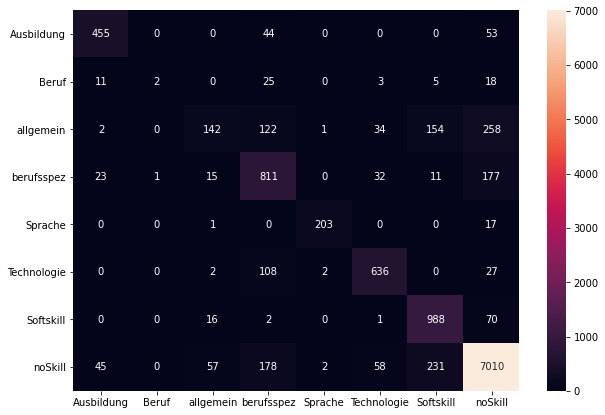

In [11]:
# Create Confusion Matrix

import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = sklearn.metrics.confusion_matrix(true_label, pred_label)
df_cm = pd.DataFrame(cm, labels,columns = labels)
plt.figure(figsize = (10,7))
plt.ylabel('Eingabe')
plt.xlabel('Ausgabe')
sn.heatmap(df_cm, annot=True,fmt='g')

In [12]:
# clean noSkill for evaluation
clean_y_pred = []
clean_y_test = []
true_noSkills = 0
clean_x_test = []
afks = []

for i in range(len(y_test)):
    if(true_label[i] != 7 or pred_label[i] != 7):
        clean_x_test.append(x_test[i])
        clean_y_pred.append(pred_label[i])
        clean_y_test.append(true_label[i])
        afks.append(test_afks[i])
    else:
        true_noSkills += 1
pred_label = clean_y_pred
true_label = clean_y_test
print('correctly labeled noSkills: ', true_noSkills)

correctly labeled noSkills:  7010


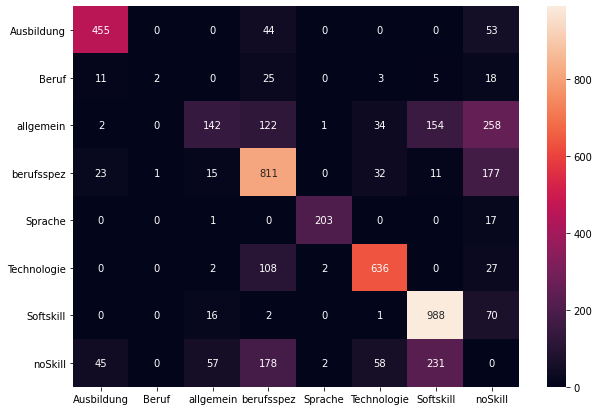

In [13]:
# Create Confusion Matrix

import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = sklearn.metrics.confusion_matrix(true_label, pred_label)
df_cm = pd.DataFrame(cm, labels,columns = labels)
plt.figure(figsize = (10,7))
plt.ylabel('Eingabe')
plt.xlabel('Ausgabe')
sn.heatmap(df_cm, annot=True,fmt='g')